# Ricerca dati Sentinel 2
Questo notebook mostra l'uso di alcune librerie preinstallate nel container per eseguire una ricerca in un catalogo STAC (Spatio Temporal Asset Catalog) di dati Sentinel-2. I risultati della ricerca sono elencati come dataframe e poi visualizzati su una mappa interattiva

In [49]:
from pystac_client import Client
import geopandas as gpd
import pandas as pd
from odc.stac import load
import odc.geo

### Connessione al catalogo STAC AWS Sentinel

In [2]:
catalog_url = "https://earth-search.aws.element84.com/v1"

catalog = Client.open(
    url=catalog_url
)

### Ricerca nel catalogo

#### Parametri

In [3]:
collection = "sentinel-2-l2a"

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
          [
            [14.023402255003418, 42.127736926471755],
            [14.023402255003418, 42.12364217276675],
            [14.030106269290513, 42.12364217276675],
            [14.030106269290513, 42.127736926471755],
            [14.023402255003418, 42.127736926471755]
          ]
    ],
}

time_of_interest = "2023-07-01/2023-07-31"

# filtri aggiuntivi per metadata 
filters = {
    "eo:cloud_cover":{"lt":0.2},
    # "s2:vegetation_percentage": {"gt": 25}
}

#### Ricerca

In [4]:
search = catalog.search(
    collections=[collection], intersects=area_of_interest, datetime=time_of_interest, query=filters
)
items = search.item_collection()
print(f"La ricerca ha trovato {len(items)} Items")

La ricerca ha trovato 2 Items


#### Visualizzazione dei risultati della ricerca

In [5]:
gdf = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
gdf

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((13.78353 42.44623, 13.80217 41.45842...",2023-07-19T18:04:09.689Z,sentinel-2a,sentinel-2,[msi],0.000598,32633,33,T,VG,...,S2A_OPER_MSI_L2A_DS_2APS_20230719T134659_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230719T134659_A0421...,0.967856,2023-07-19T10:09:07.776000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/33/T/V...,roda-sentinel2/workflow-sentinel2-to-stac/1607...,True,{'sentinel2-to-stac': '0.1.1'},2023-07-19T18:04:09.689Z
1,"POLYGON ((13.81736 42.44658, 13.78559 42.33928...",2023-07-16T18:54:49.968Z,sentinel-2a,sentinel-2,[msi],0.001379,32633,33,T,VG,...,S2A_OPER_MSI_L2A_DS_2APS_20230716T141155_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230716T141155_A0421...,0.967609,2023-07-16T09:59:12.378000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/33/T/V...,roda-sentinel2/workflow-sentinel2-to-stac/f807...,True,{'sentinel2-to-stac': '0.1.1'},2023-07-16T18:54:49.968Z


In [6]:
gdf.explore()

## Recupero dei dati dagli item 
Attraverso odc-stac si convertono i dati in **xarray Dataset** 

### Dataset

In [51]:
data = load(search.items(), geopolygon=area_of_interest, chunks={})
data

<xarray.Dataset> Size: 362kB
Dimensions:       (y: 48, x: 57, time: 2)
Coordinates:
  * y             (y) float64 384B 4.664e+06 4.664e+06 ... 4.664e+06 4.664e+06
  * x             (x) float64 456B 4.193e+05 4.193e+05 ... 4.198e+05 4.198e+05
    spatial_ref   int32 4B 32633
  * time          (time) datetime64[ns] 16B 2023-07-16T09:59:12.378000 2023-0...
Data variables: (12/32)
    aot           (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    blue          (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    coastal       (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    green         (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    nir           (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    nir08         (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    ...            ...
    rededge3-jp2  (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    scl-jp2       (time, y, x) uint8 5kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    swir16-jp2    (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    swir22-jp2    (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    visual-jp2    (time, y, x) float32 22kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>
    wvp-jp2       (time, y, x) uint16 11kB dask.array<chunksize=(1, 48, 57), meta=np.ndarray>

#### Plot banda red per tutti i timestamp

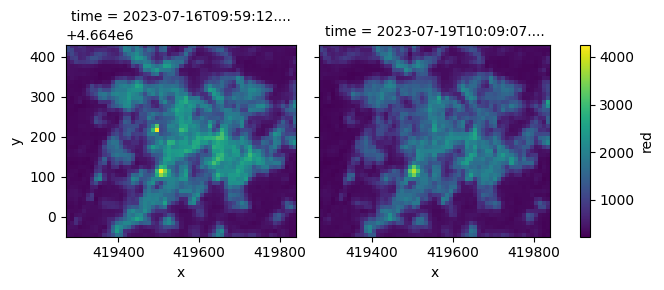

In [31]:
data['red'].plot.imshow(col="time")

#### Esempio calcolo indici: NDVI

In [37]:
ndvi = (data.nir - data.red)/(data.nir + data.red)

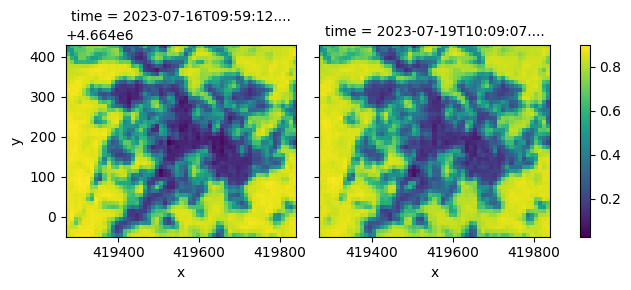

In [39]:
ndvi.plot.imshow(col="time")

#### Esportazione in formato tiff

In [53]:
for time_index in range(len(ndvi.time)):
    date = str(ndvi.time[time_index].values)
    formatted_date = pd.to_datetime(str(date)).strftime('%d-%m-%Y')
    # print(formatted_date)
    odc.geo.xr.write_cog(ndvi.isel(time=time_index),fname=f'ndvi_{formatted_date}.tiff',  overwrite=True)